In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from os.path import join, exists
from scipy.io import wavfile
import pickle
import json
from pprint import pprint
from IPython.display import Audio, display

import sys

sys.path.append('../model/')

from song_fitter import SongModel, get_scores
import synth

sns.set_palette('colorblind')

In [2]:
path = '../model/res/170321_153812_big_ba_new_green_prior/'
if exists(join(path, 'aborted.txt')):
    raise ValueError('Aborted run')

In [3]:
sr, tutor = wavfile.read(join(path, 'tutor.wav'))
with open(join(path, 'params.json'), 'r') as f:
    run_param = json.load(f)

In [4]:
pprint(run_param)

{'commit': '1379c3c3e4348af2af2fc9b35eee2b497cf9a1c6',
 'comp': 'linalg',
 'concurrent': 3,
 'days': 50,
 'iter_per_train': 20,
 'name': 'big_ba_new_green_prior',
 'replay': 5,
 'seed': 1490107092,
 'train_per_day': 100,
 'tutor': '../data/ba_example.wav'}


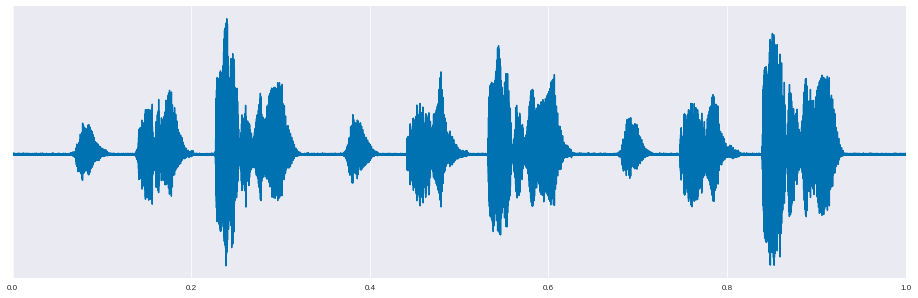

In [5]:
with sns.plotting_context('paper'):
    fig = plt.figure(figsize=(16, 5))
    ax = fig.gca()
    ax.plot(np.r_[0:len(tutor)//44100:len(tutor)*1j], tutor)
    ax.set_yticks([])
    ax.set_xlim((0, len(tutor)//44100))
    plt.show()

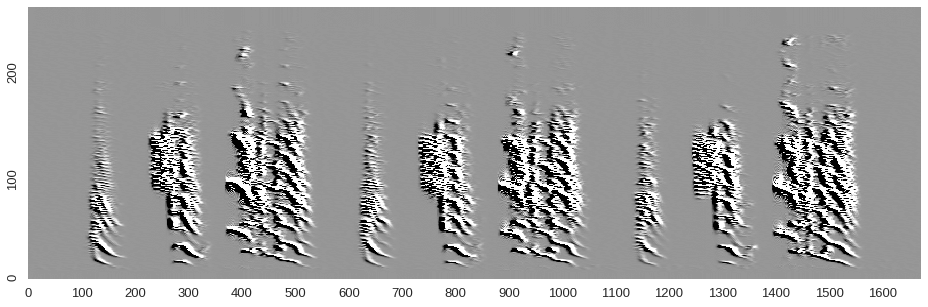

In [6]:
tspec = bsa.spectral_derivs(tutor, 256, 40, 1024)
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
plt.show(fig)

In [7]:
outputs = []
for i in range(run_param['concurrent']):
    outputs.append(wavfile.read(join(path, 'out_{}.wav'.format(i)))[1])

FileNotFoundError: [Errno 2] No such file or directory: '../model/res/170321_153812_big_ba_new_green_prior/out_0.wav'

In [ ]:
display(Audio(tutor, rate=44100))

In [ ]:
for output in outputs:
    display(Audio(output, rate=44100))

In [ ]:
run = True  # Disabled because very long.
if run:
    for out in outputs:
        sim = bsa.similarity(out, tutor)
        bsa.similarity_plot(sim, out, tutor)
        print(sim['similarity'])

In [ ]:
tfeat = bsa.all_song_features(tutor, 44100)
sfeat = bsa.all_song_features(outputs[0], 44100)

In [ ]:
for fname in tfeat:
    plt.figure(figsize=(16, 5))
    plt.plot(tfeat[fname])
    plt.plot(sfeat[fname])
    plt.title(fname)
    plt.show()

In [ ]:
plt.figure(figsize=(16, 5))

plt.plot(tfeat['amplitude'], label="tutor")
plt.plot(sfeat['amplitude'], label="synth")
plt.legend()
plt.show()

In [ ]:
with open(join(path, 'songs.pkl'), 'rb') as f:
    smodels = pickle.load(f)

In [ ]:
len(smodels[1].gestures)

In [ ]:
ab = []
for i, gesture in enumerate(smodels[0].gestures):
    p = gesture[1]
    start = gesture[0]
    try:
        end = smodels[0].gestures[i+1][0]
    except IndexError:
        end = len(tutor)
    size = end - start
    ab.append(synth.gen_alphabeta(p, size, falpha=lambda x, p: synth.only_sin(x, p, nb_sin=3),
                fbeta=lambda x, p: synth.only_sin(x, p, nb_sin=1),
                falpha_nb_args=13, beg=0))
ab = np.concatenate(ab)

IndexError: list index out of range

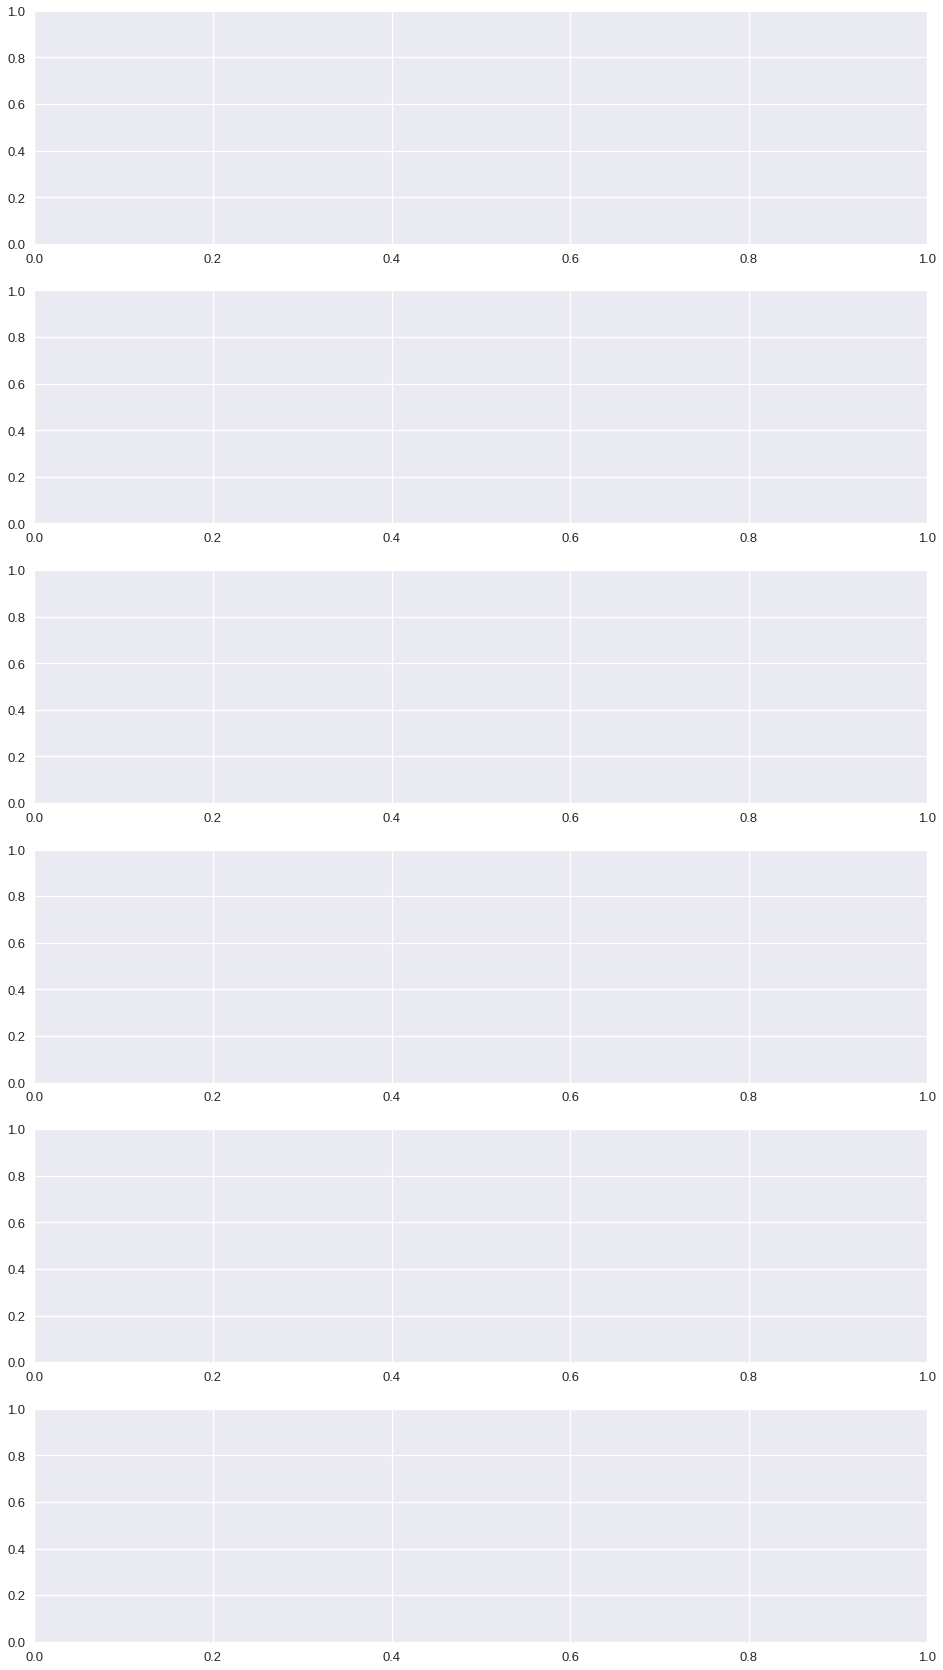

In [36]:
from os.path import basename


fig, axs = plt.subplots(6, 1, figsize=(16, 5*6))
ospec = bsa.spectral_derivs(outputs[0], 256, 40, 1024)
bsa.spectral_derivs_plot(ospec, contrast=0.01, ax=axs[0])
bsa.plot_over_spec(sfeat['amplitude'], ax=axs[0])
axs[0].set_xlim(0, ospec.shape[0])
axs[1].plot(ab[:, 0])
axs[1].set_xlim((0, ab.shape[0]))
axs[2].plot(ab[:, 1], color="g")
axs[2].set_xlim((0, ab.shape[0]))
bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=axs[3])
bsa.plot_over_spec(tfeat['amplitude'], ax=axs[3])

tutor_params = np.loadtxt('../data/{}_ab.dat'.format(basename(run_param['tutor']).split('.')[0]))
axs[4].plot(tutor_params[:, 0])
axs[4].set_xlim((0, tutor_params.shape[0]))
axs[5].plot(tutor_params[:, 1], c="g")
axs[5].set_xlim((0, tutor_params.shape[0]))


for i, gesture in enumerate(smodels[0].gestures):
    start = gesture[0]
    #axs[0].axvline(x=start/40, color="k", linewidth=1)
    #axs[1].axvline(x=start, color="k", linewidth=1)
    #axs[2].axvline(x=start, color="k", linewidth=1)
    #axs[3].axvline(x=start/40, color="k", linewidth=1)
    #axs[4].axvline(x=start, color="k", linewidth=1)
    #axs[5].axvline(x=start, color="k", linewidth=1)

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(tutor_params[:, 1], alpha=0.3)
plt.plot(ab[:, 1], alpha=0.7)
plt.xlim(0, ab.shape[0])
for i, gesture in enumerate(smodels[0].gestures):
    start = gesture[0]
    plt.axvline(x=start, color="k", linewidth=1)

In [ ]:
gtes = np.loadtxt('../data/{}_gte.dat'.format(basename(run_param['tutor']).split('.')[0]))
true_gtes = gtes[np.concatenate(((np.diff(gtes) > 100), (False,)))]

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(np.arange(28000, 35000), tutor_params[28000:35000])
#plt.plot(ab[:, 0], alpha=0.5)
plt.xlim(28000, 35000)
plt.xticks([])
plt.yticks([])
for gte in true_gtes:
    start = gesture[0]
    plt.axvline(x=gte, color="k", linewidth=1)

In [ ]:
len(true_gtes)

In [ ]:
np.mean(np.diff(true_gtes))

In [ ]:
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
ax.set_xlim(0, ab.shape[0]/40)
for gte in true_gtes:
    ax.axvline(x=gte/40, color="k", linewidth=1)

# Analysis of the song log

In [39]:
try:
    with open(join(path, 'data.pkl'), 'rb') as f:
        songlog = pickle.load(f)
except FileNotFoundError:
    import warnings
    warnings.warn('warning, learning not over')
    with open(join(path, 'data_cur.pkl'), 'rb') as f:
        songlog = pickle.load(f)

/home/ecoffet/.virtualenvs/birdsongs/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: warning, learning not over


In [40]:
import pandas

In [41]:
root_data = [item[1] for item in songlog if item[0] == 'root']

In [42]:
rd = pandas.DataFrame(root_data)

In [43]:
rd['songs'][0]

In [44]:
day_opt = pandas.DataFrame([elem[1] for elem in songlog if elem[0] == 'day_optim'])

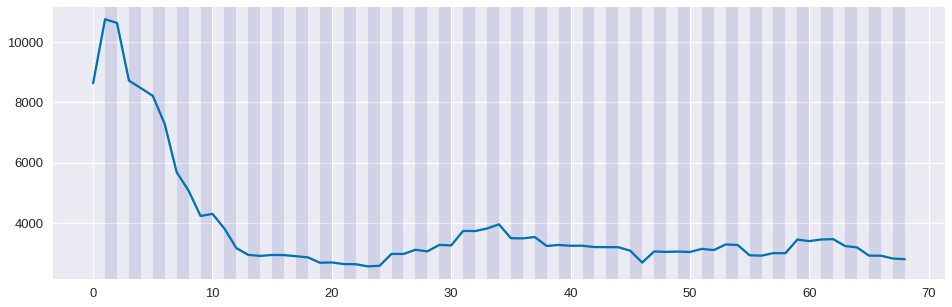

In [45]:
plt.figure(figsize=(16, 5))
for i in range(1, len(rd['scores']), 2):
    plt.axvspan(i, i+1, facecolor='darkblue', alpha=0.1)
plt.plot(rd['scores'].apply(np.min))
#plt.xticks(range(len(rd['scores'])), rd['moment'], rotation=75)
plt.show()

In [46]:
np.median(np.array(rd['scores'].apply(np.min)[2::2]) - np.array(rd['scores'].apply(np.min)[1:-2:2]))

ValueError: operands could not be broadcast together with shapes (34,) (33,) 

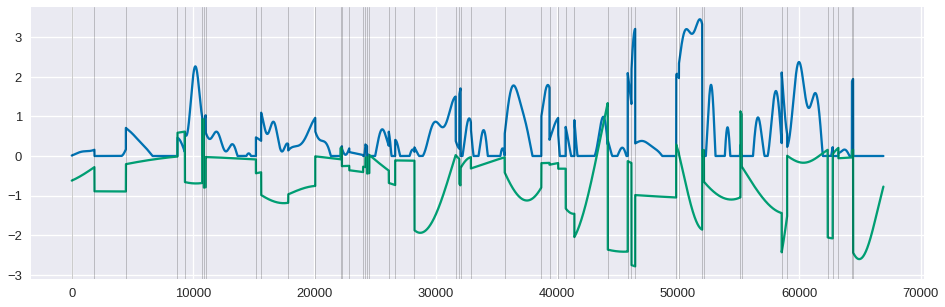

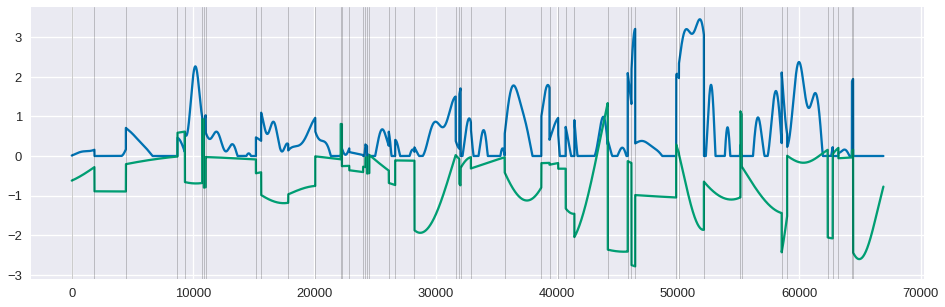

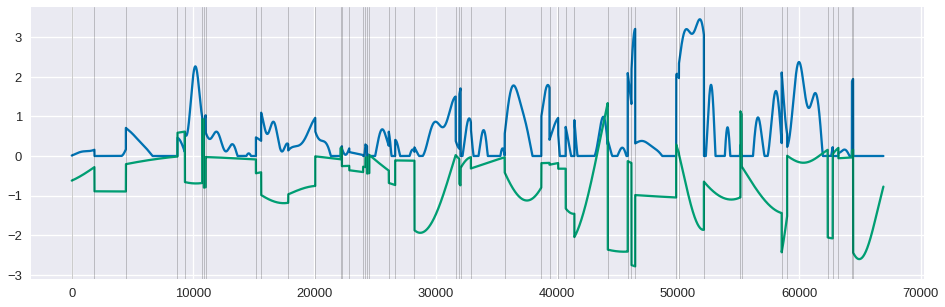

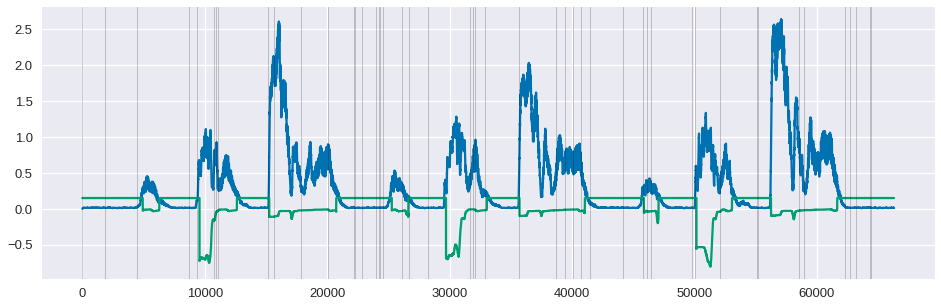

In [47]:
tutor_params = np.loadtxt('../data/{}_ab.dat'.format(basename(run_param['tutor']).split('.')[0]))

for i in range(len(rd['songs'].iloc[-1])):
    plt.figure(figsize=(16, 5))
    plt.plot(rd['songs'].iloc[-1][i].gen_alphabeta())
    for gesture in rd['songs'].iloc[-1][i].gestures:
        start = gesture[0]
        plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
plt.figure(figsize=(16,5))
plt.plot(tutor_params)
for gesture in rd['songs'].iloc[-1][i].gestures:
    start = gesture[0]
    plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
plt.show()

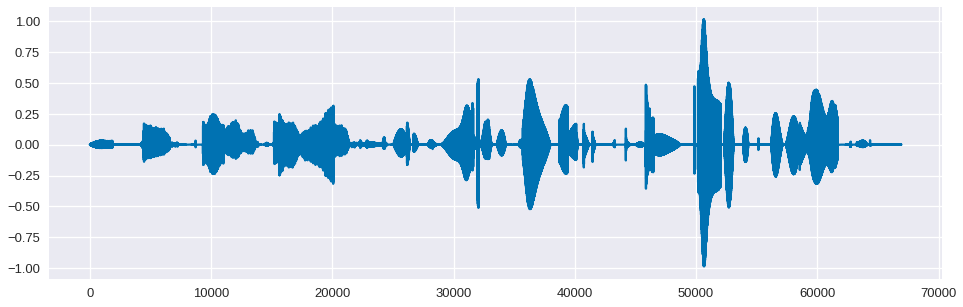

In [48]:
plt.figure(figsize=(16, 5))
plt.plot(rd['songs'].iloc[-1][0].gen_sound())

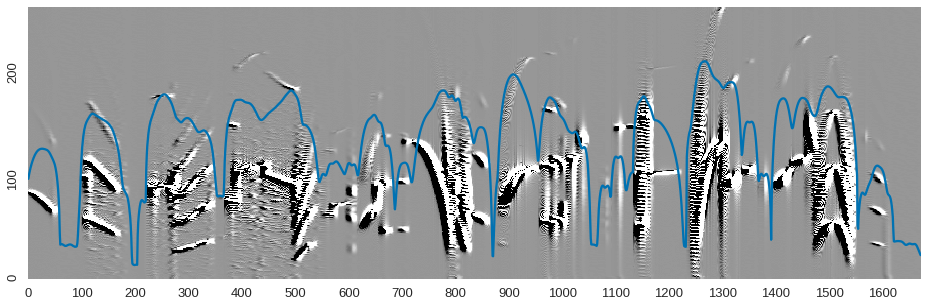

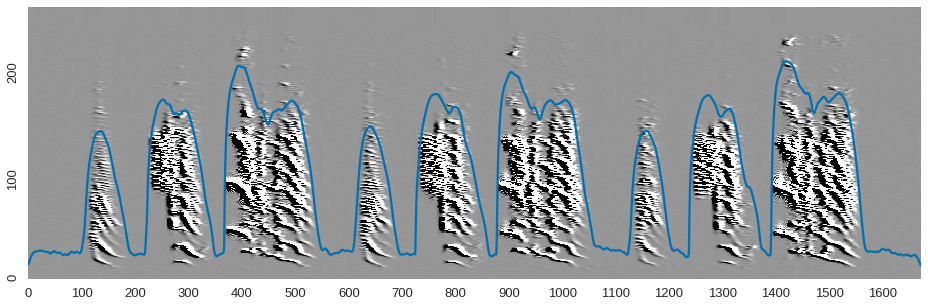

In [49]:
from synth import synthesize
ab = rd['songs'].iloc[-1][1].gen_alphabeta()
s = synthesize(ab)
display(Audio(s, rate=44100))
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
bsa.spectral_derivs_plot(bsa.spectral_derivs(s, 256, 40, 1024), contrast=0.001, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(s, 256, 40, 1024), ax=ax)
plt.show()
display(Audio(tutor, rate=44100))
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
bsa.spectral_derivs_plot(bsa.spectral_derivs(tutor, 256, 40, 1024), contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(tutor, 256, 40, 1024), ax=ax)
plt.show()

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(tutor_params[28000:35000])